In [1]:
import csv
import cv2
import numpy as np
import random 
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

lines=[]

# with open('./data/driving_log_bkp.csv') as csvfile:
#     reader = csv.reader(csvfile)
#     for line in reader:
#         lines.append(line)
def process_shade(image):
    h, w = image.shape[0], image.shape[1]
    [x1, x2] = np.random.choice(w, 2, replace=True)
    k = h / (0.0001+x2 - x1)
    b = - k * x1
    for i in range(h):
        c = int((i - b) / (k+0.0001))
        image[i, :c, :] = (image[i, :c, :] * .65).astype(np.int32)
    return image        

In [2]:
images = []
measurements = []

In [3]:
# log_pd = pd.read_csv('im/driving_log.csv')
log_pd = pd.read_csv('data/driving_log_2.csv')

In [4]:
measurements = log_pd['steering']
image_fname = log_pd['center']
image_rname = log_pd['right']
image_lname = log_pd['left']

In [5]:
print(measurements.shape)
print(image_fname.shape)
print(measurements[0:2])
print(image_fname[0:2])
print(type(measurements))
print(type(image_fname))
measurements=np.array(measurements)
print(type(measurements))


(14302,)
(14302,)
0    0.0
1    0.0
Name: steering, dtype: float64
0    IMG/center_2016_12_01_13_30_48_287.jpg
1    IMG/center_2016_12_01_13_30_48_404.jpg
Name: center, dtype: object
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


### Histogram of Steering Angles

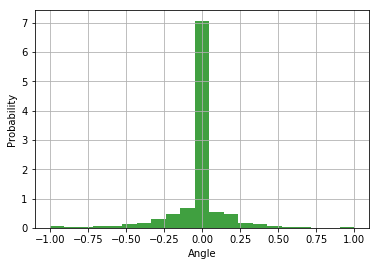

In [6]:
n, bins, patches = plt.hist(measurements, 21, normed=1, facecolor='green', alpha=0.75)

plt.xlabel('Angle')
plt.ylabel('Probability')

plt.grid(True)

plt.show()

In [7]:
y=[]

for i in range(len(image_fname)):
    
# The neutral steering angle is undersampled (Only 20% of the collected data is used for training)            
    if((measurements[i]==0)&(random.random()<0.8)):
        continue
    else:
        if(measurements[i]!=0):
#             image = cv2.imread('im/' + image_rname[i].lstrip())
            image = cv2.imread('data/' + image_rname[i].lstrip())
# 10% of the images are post-processed so that the model can learn different shade/lighting conditions    
            if(random.random()>0.9):
                image=process_shade(image)
            images.append(image)
            y.append(measurements[i]-0.25)       
#             image = cv2.imread('im/' + image_lname[i].lstrip())
            image = cv2.imread('data/' + image_lname[i].lstrip())
            if(random.random()>0.9):
                image=process_shade(image)
            images.append(image)
            y.append(measurements[i]+0.25)   
#         image = cv2.imread('im/' + image_fname[i].lstrip())
        image = cv2.imread('data/' + image_fname[i].lstrip())
        
        if(random.random()>0.90):
            image=process_shade(image)
        images.append(image)
        y.append(measurements[i])            

In [8]:
temp_x = np.array(images)
temp_y = np.array(y)

The histogram after undersampling of neutral steering angles

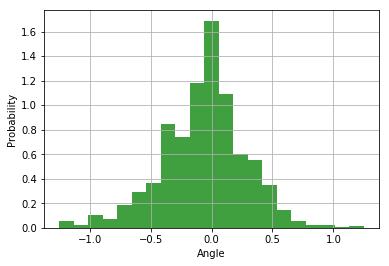

In [9]:
n, bins, patches = plt.hist(temp_y, 21, normed=1, facecolor='green', alpha=0.75)

plt.xlabel('Angle')
plt.ylabel('Probability')

plt.grid(True)

plt.show()

In [10]:
print(temp_x.shape)
print(temp_y.shape)

(17408, 160, 320, 3)
(17408,)


The data is augmented by flipping the images and reversing the steering angle

In [11]:
X_train = np.append(temp_x,np.fliplr(temp_x),axis=0)
y_train = np.append(temp_y,-1.0*temp_y,axis=0)

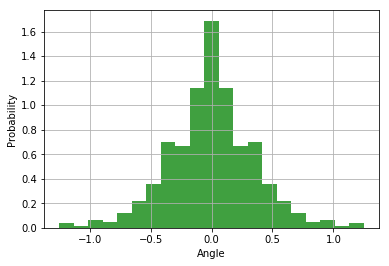

In [12]:

n, bins, patches = plt.hist(y_train, 21, normed=1, facecolor='green', alpha=0.75)

plt.xlabel('Angle')
plt.ylabel('Probability')

plt.grid(True)

plt.show()

In [13]:
print(X_train.shape)
print(y_train.shape)

(34816, 160, 320, 3)
(34816,)


Final Model is 6-epoch

Using TensorFlow backend.


Train on 27852 samples, validate on 6964 samples
Epoch 1/6
27852/27852 [==============================] - 56s - loss: 0.1107 - val_loss: 0.1447

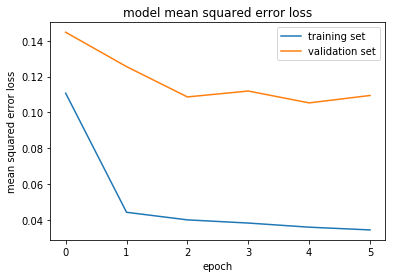

In [14]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense
from keras.layers import Convolution2D, Cropping2D, MaxPooling2D
from keras.layers import Lambda

model = Sequential()

model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25),(0,0))))
model.add(Convolution2D(24, 5, 5, activation = 'relu', subsample=(2, 2) ))

model.add(Convolution2D(36, 5, 5, activation = 'relu', subsample=(2, 2) ))

model.add(Convolution2D(48, 5, 5, activation = 'relu', subsample=(2, 2) ))

model.add(Convolution2D(64, 3, 3, activation = 'relu' ))
# model.add(MaxPooling2D())

model.add(Convolution2D(64, 3, 3))
# model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

# model.add(MaxPooling2D())
# model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(1162))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

model_history = model.fit(X_train,y_train, validation_split=0.2,shuffle=True, nb_epoch=6,batch_size=256)
model.save('model.h5')
    
    
print(model_history.history.keys())

### plot the training and validation loss for each epoch
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()    

10 EPoch

Train on 27852 samples, validate on 6964 samples
Epoch 1/10
27852/27852 [==============================] - 53s - loss: 0.0676 - val_loss: 0.1317

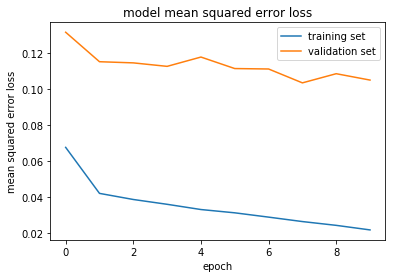

In [15]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense
from keras.layers import Convolution2D, Cropping2D, MaxPooling2D
from keras.layers import Lambda

model = Sequential()

model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25),(0,0))))
model.add(Convolution2D(24, 5, 5, activation = 'relu', subsample=(2, 2) ))

model.add(Convolution2D(36, 5, 5, activation = 'relu', subsample=(2, 2) ))

model.add(Convolution2D(48, 5, 5, activation = 'relu', subsample=(2, 2) ))

model.add(Convolution2D(64, 3, 3, activation = 'relu' ))
# model.add(MaxPooling2D())

model.add(Convolution2D(64, 3, 3))
# model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

# model.add(MaxPooling2D())
# model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(1162))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

model_history = model.fit(X_train,y_train, validation_split=0.2,shuffle=True, nb_epoch=10,batch_size=256)
model.save('model_temp_cont_10ep_out_2.h5')
    
    
print(model_history.history.keys())

### plot the training and validation loss for each epoch
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()    